In [1]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

### Funcs

In [2]:
def plot_trajectory(time, position):
    plt.figure(figsize=(10, 7))
    plt.plot(position[:, 0], position[:, 1], label="Trajectory")
    plt.scatter(position[0, 0], position[0, 1], color="green", label="Start", s=50)
    plt.scatter(position[-1, 0], position[-1, 1], color="red", label="End", s=50)
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.legend()
    plt.title('Trajectory in XY Plane')
    plt.grid()
    plt.show()

    # Plot Z position over time to verify constant height
    plt.figure(figsize=(10, 5))
    plt.plot(time, position[:, 0], label="X Position", color='red')
    plt.plot(time, position[:, 1], label="Y Position", color='green')
    plt.plot(time, position[:, 2], label="Z Position", color='blue')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    plt.title('Positions Over Time')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot the trajectory
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(position[:, 0], position[:, 1], position[:, 2], label="Trajectory")
    ax.scatter(position[0, 0], position[0, 1], position[0, 2], color="green", label="Start", s=50)
    ax.scatter(position[-1, 0], position[-1, 1], position[-1, 2], color="red", label="End", s=50)
    ax.set_xlabel('X Position (m)')
    ax.set_ylabel('Y Position (m)')
    ax.set_zlabel('Z Position (m)')
    ax.legend()
    plt.show()
    
def trajectory(time, ang_vel, acceleration):
    """Ang vel need to be in rad/s"""
    diff_t = np.diff(time)
    orientations = []
    orientations.append(R.from_euler('xyz', [np.pi, 0, 0])) # It starts facing down (seen from the gravity acceleration from the accelerometer)

    for ang_v, dt in zip(ang_vel[1:], diff_t):
        omega = ang_v * dt
        delta_rot = R.from_euler('xyz', omega)
        orientations.append(orientations[-1] * delta_rot)

    position = [[0]*3]
    gravity = np.array([0, 0, -9.81])  # Gravity
    velocity = [0,0,0]
    
    for current_orientation, acc, dt in zip(orientations[1:], acceleration[1:], diff_t):
        # Rotate to world frame
        acc_world = current_orientation.apply(acc)
        # Subtract gravity
        acc_world = acc_world - gravity

        velocity = velocity + acc_world * dt
        position.append(position[- 1] + velocity * dt)
    
    plot_trajectory(time, np.array(position))   
    
def normalize_angle(angle):
    for i in range(len(angle[-1])):
        angle[-1][i] = (angle[-1][i] + 180) % 360 - 180
    return angle

def orientation_from_ang_vel(time, angular_vel):
    orientation = [[180,0,0]] #Initial orientation extracted by looking at the acceleration data (measuring the gravity acceleration at the beginning)
    normalize_angle(orientation)
    diff_t = np.diff(time)
    for ang_vel, dt in zip(angular_vel[1:], diff_t):
        orientation.append(orientation[-1] + ang_vel * dt)
        normalize_angle(orientation)

    orientation = np.radians(orientation)

    plt.figure(figsize=(15, 5))
    plt.plot(time, orientation)
    plt.xlabel('Time (s)')
    plt.ylabel('Orientation (deg)')
    plt.legend(['Roll', 'Pitch', 'Yaw'])
    plt.grid()
    
def plot_data(time, angular_vel, acceleration, title):
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    plt.title(title)
    plt.plot(time,angular_vel[:, 0], color='red')
    plt.plot(time,angular_vel[:, 1], color='green')
    plt.plot(time,angular_vel[:, 2], color = 'blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Angular velocity (deg/s)')
    plt.legend(['$w_X$', '$w_Y$', '$w_Z$'])
    plt.grid()
    plt.subplot(2, 1, 2)
    plt.plot(time,acceleration[:, 0], color='red')
    plt.plot(time,acceleration[:, 1], color='green')
    plt.plot(time,acceleration[:, 2], color = 'blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s^2)')
    plt.legend(['$a_X$', '$a_Y$', '$a_Z$'])
    plt.grid()


### LOAD DATA 

In [3]:
with open('LAB1_25.TXT', 'r') as file:
    data = np.array([list(map(float, line.split())) for line in file])
time = data[:, 0] * 10**-6

# TASK 1

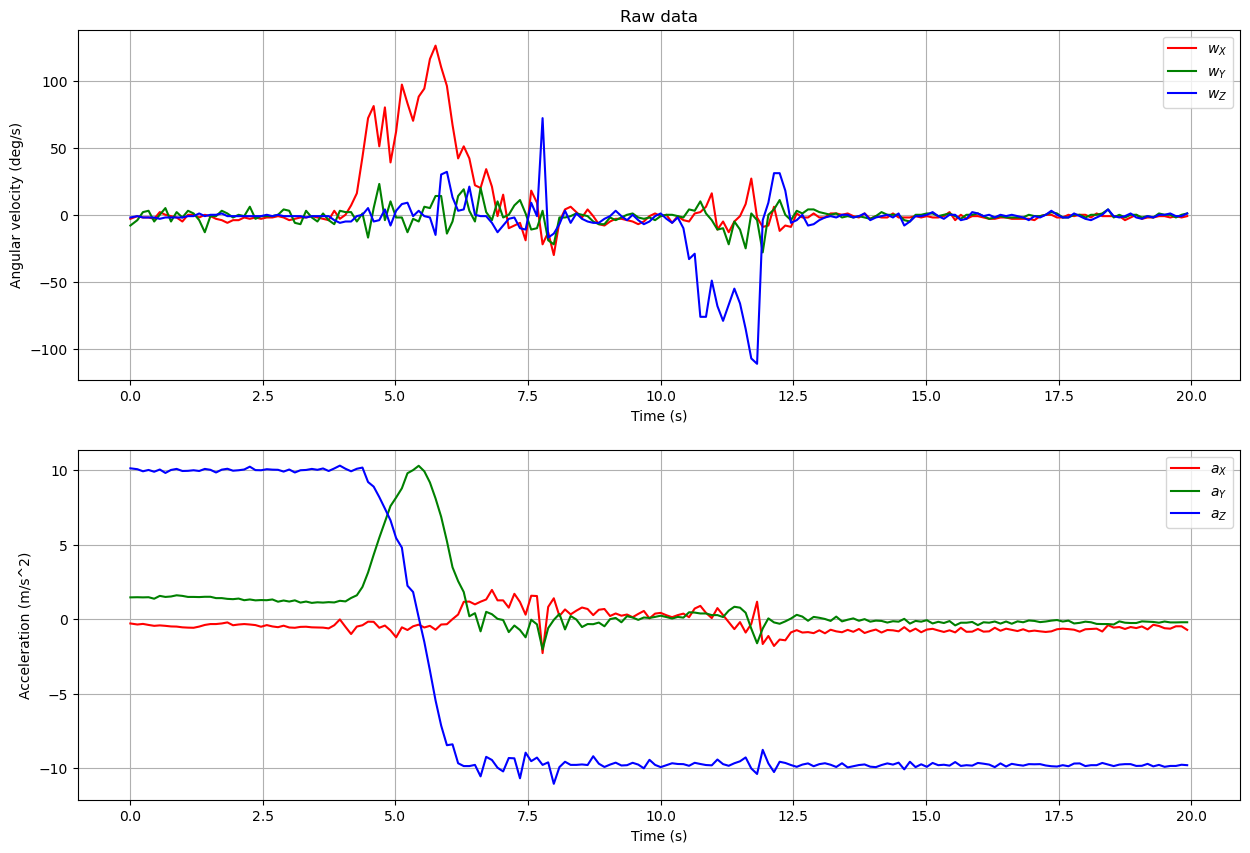

In [4]:
#accelerometer data(hundredths of meters per second squared)
acceleration = data[:, 1:4] * 0.01
#gyro-rate (degrees per second)
angular_velocity = data[:, 4:7]

plot_data(time, angular_velocity, acceleration, 'Raw data')

### Trajectory

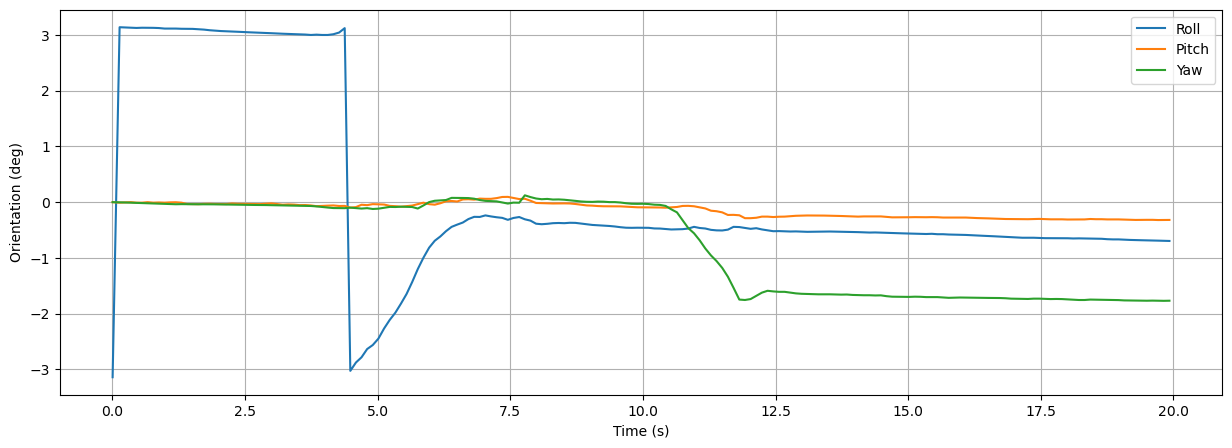

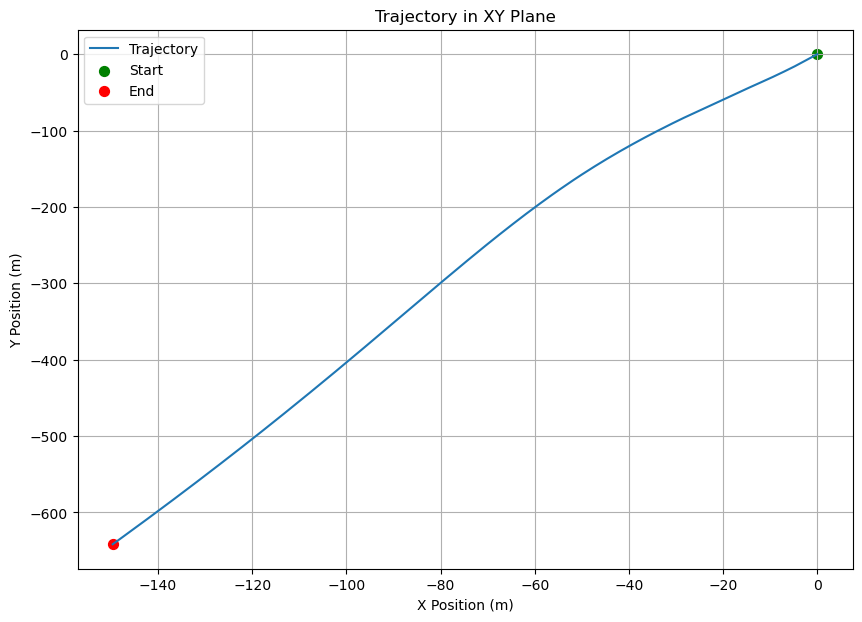

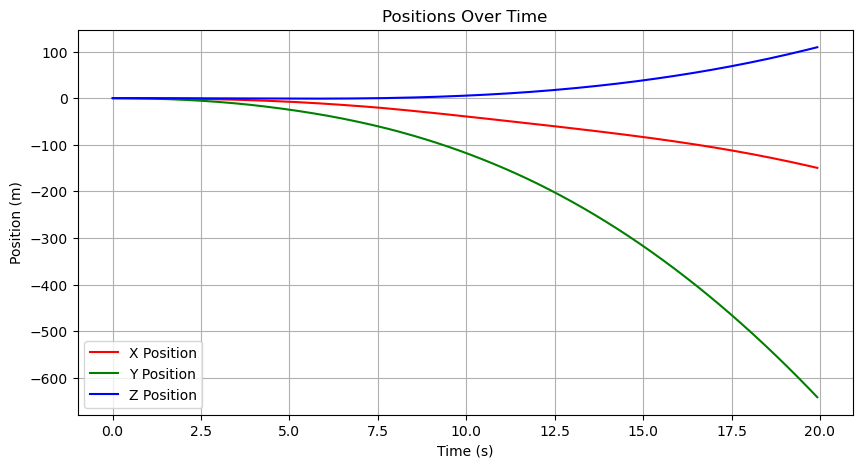

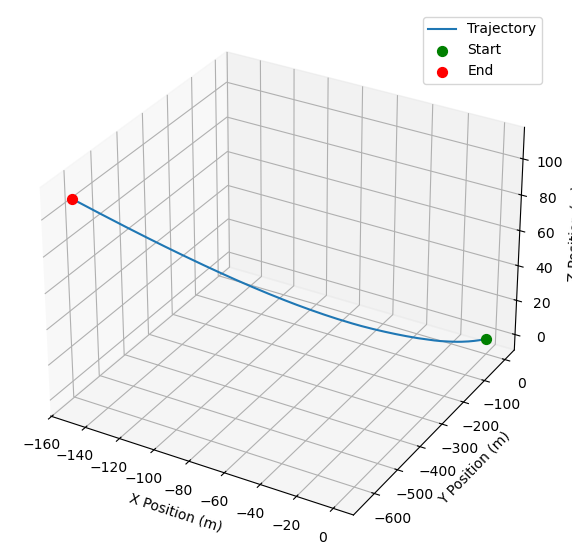

In [5]:
orientation_from_ang_vel(time, angular_velocity)
trajectory(time, np.deg2rad(angular_velocity), acceleration)

# Task2

### Reduce noise by creating a threshold 

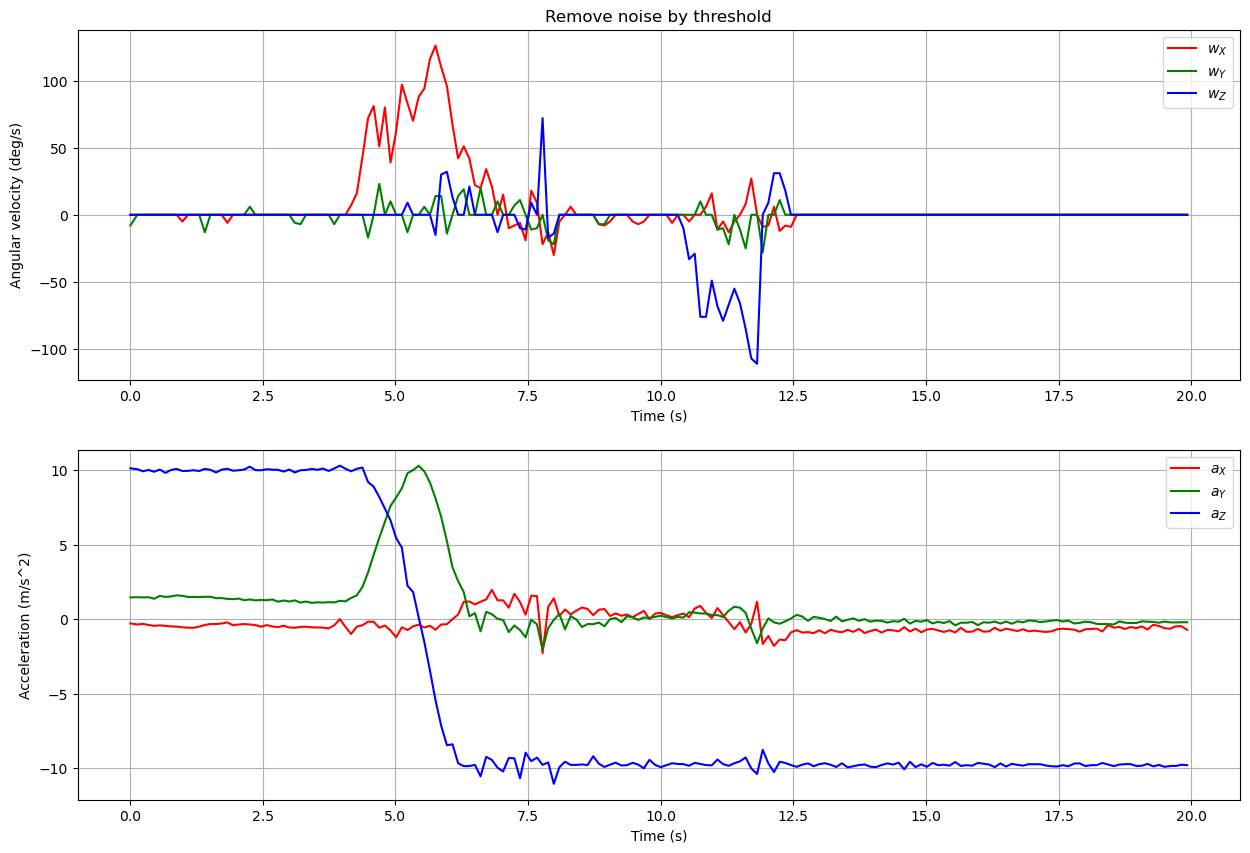

In [6]:
#Measure the variance of the data
static_arm_time = time > 15
var_ang_vel = np.var(angular_velocity[static_arm_time], axis=0)
mask = (angular_velocity > 3 * var_ang_vel) | (angular_velocity < -3 * var_ang_vel)
angular_velocity = np.where(mask, angular_velocity, 0)
var_acceleration = np.var(acceleration[static_arm_time], axis=0)
mask = (acceleration > 3 * var_acceleration) | (acceleration < -3 * var_acceleration)
acceleration = np.where(mask, acceleration,0)

plot_data(time, angular_velocity, acceleration, 'Remove noise by threshold')

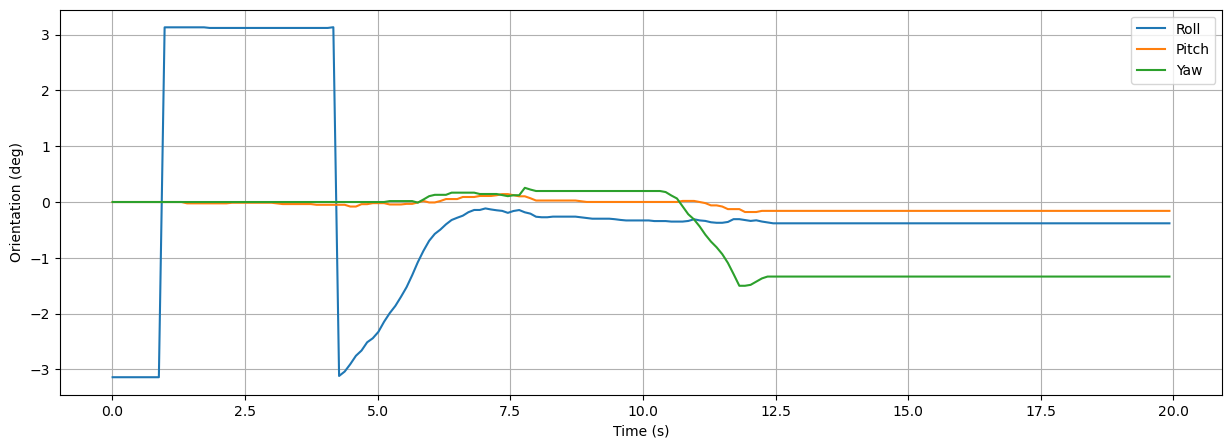

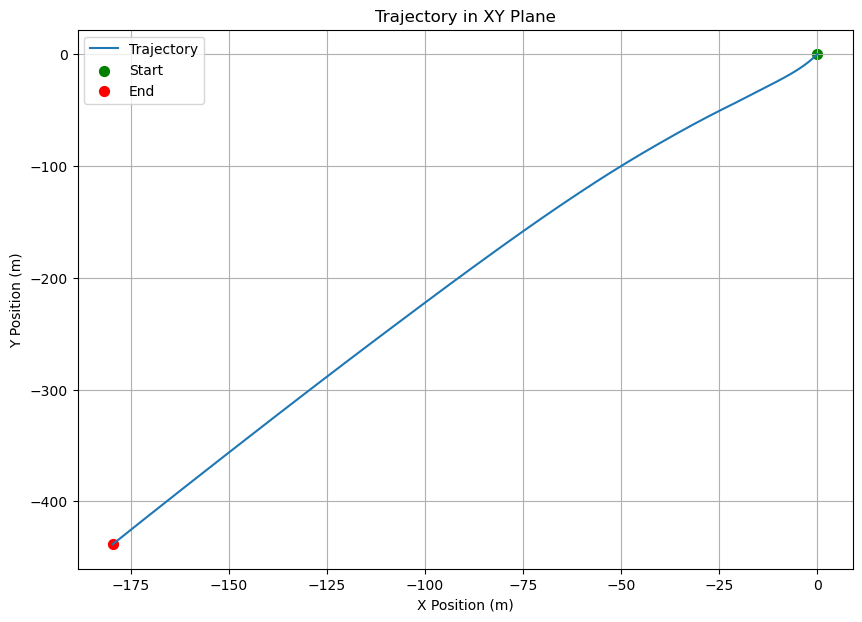

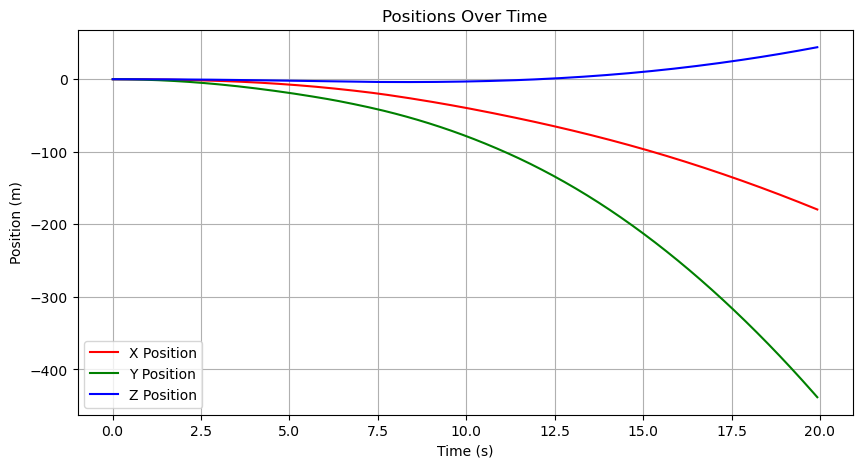

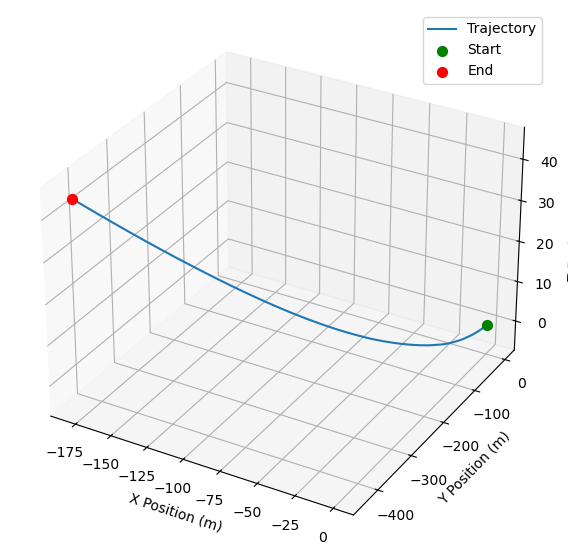

In [7]:
orientation_from_ang_vel(time, angular_velocity)
trajectory(time, np.deg2rad(angular_velocity), acceleration)

# Apply filters

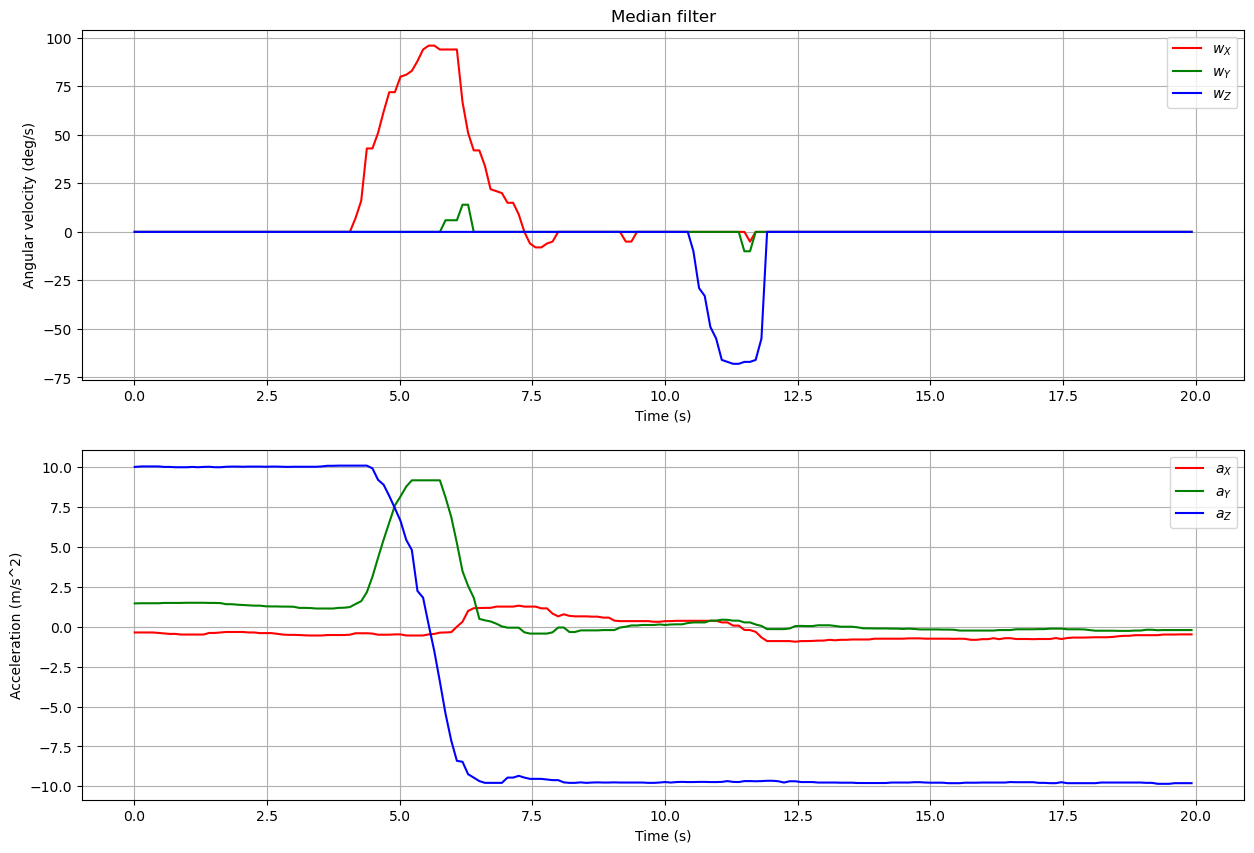

In [8]:
def keep_only_moving(data, axis_moving_data):
    num_points, num_axis = data.shape
    for i in range(num_points):
        data_point = data[i]
        axis_moving = axis_moving_data[i]
        for j in range(num_axis):
            if j != axis_moving:
                data_point[j] = 0
    return data

filtered_ang_vel = median_filter(angular_velocity, size=(10,1))
filtered_acceleration = median_filter(acceleration, size=(10,1))
# axis_moving = np.argmax(filtered_ang_vel, axis=1)
# filtered_ang_vel_max = keep_only_moving(filtered_ang_vel, axis_moving)
# plt.figure(figsize=(15, 10))
# plt.subplot(2, 1, 1)
# plt.plot(time,filtered_ang_vel[:, 0], color='red')
# plt.plot(time,filtered_ang_vel[:, 1], color='green')
# plt.plot(time,filtered_ang_vel[:, 2], color = 'blue')
# plt.plot(time,filtered_ang_vel_max[:, 0], color='red', linestyle='--')
# plt.plot(time,filtered_ang_vel_max[:, 1], color='green', linestyle='--')
# plt.plot(time,filtered_ang_vel_max[:, 2], color='blue', linestyle='--')
plot_data(time, filtered_ang_vel, filtered_acceleration, 'Median filter')


#### Check rotation

In [9]:
Initial_roll = 0
for i in range(39, 70):
    dt = time[i] - time[i-1]
    Initial_roll += filtered_ang_vel[i, 0] * dt
    # print(f'{Initial_roll:=}, {i=:}, {time[i]=:}, {filtered_ang_vel[i, 0]=:}, {dt=:}')
print(Initial_roll)

180.14211999999998


# Orientation

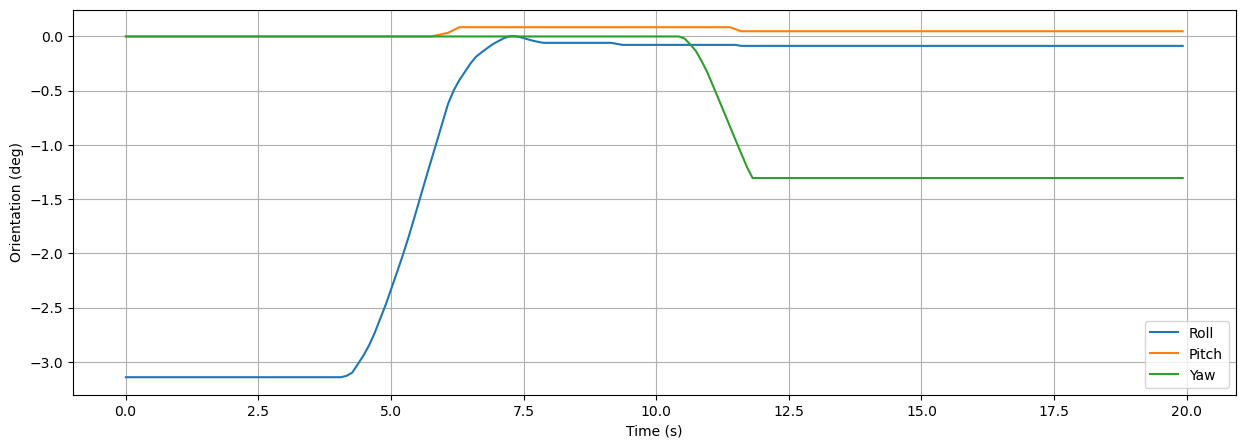

In [10]:
orientation_from_ang_vel(time, filtered_ang_vel)

# Trajetória

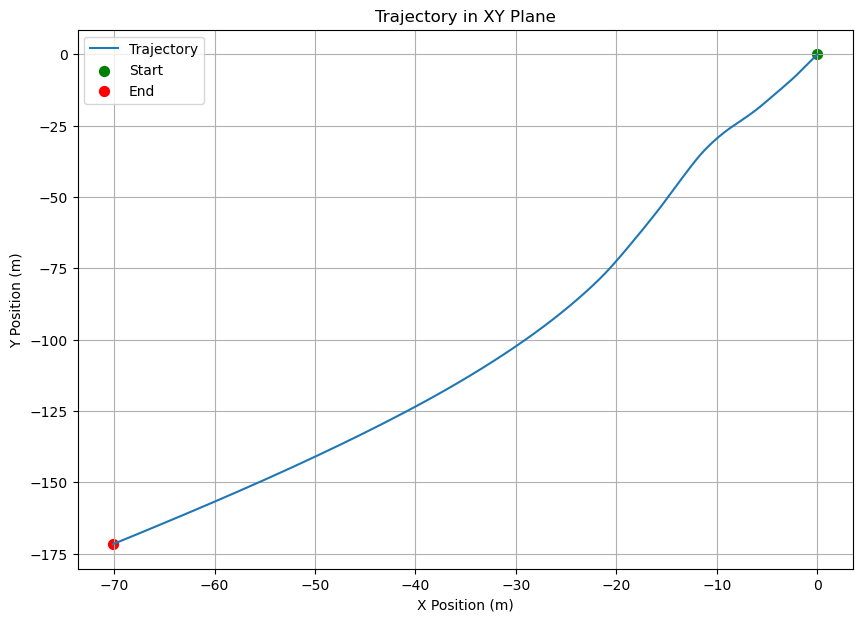

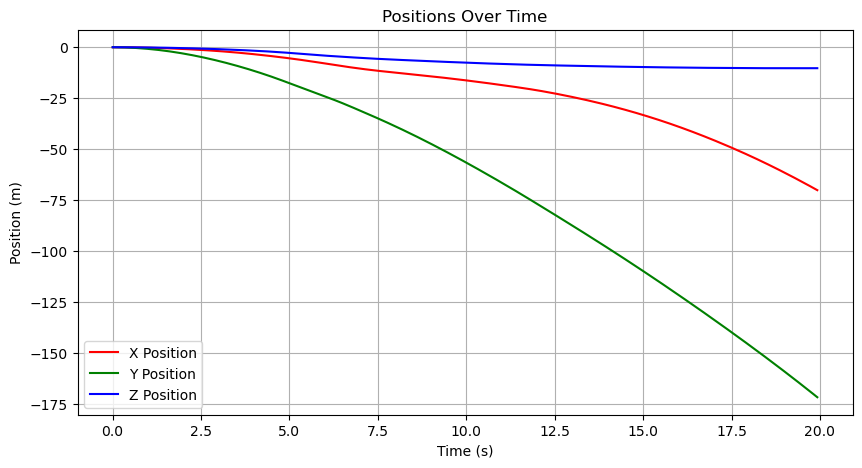

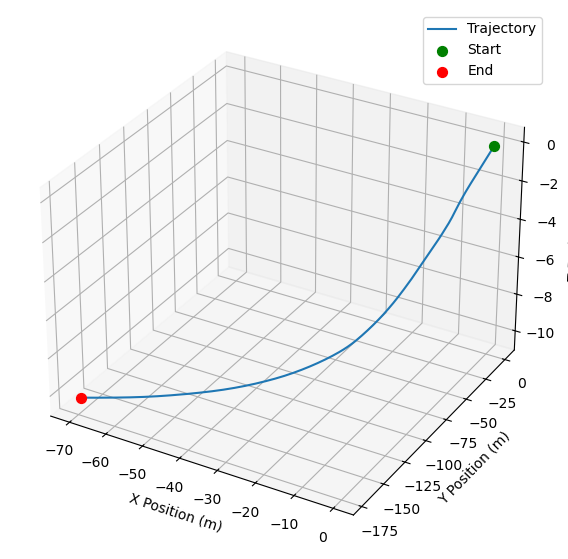

In [11]:
trajectory(time, np.deg2rad(filtered_ang_vel), filtered_acceleration)

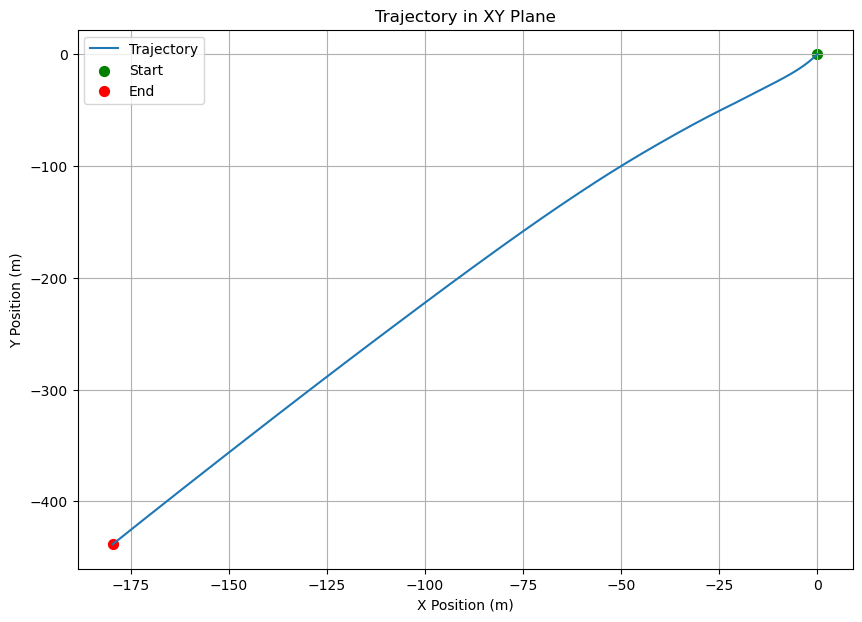

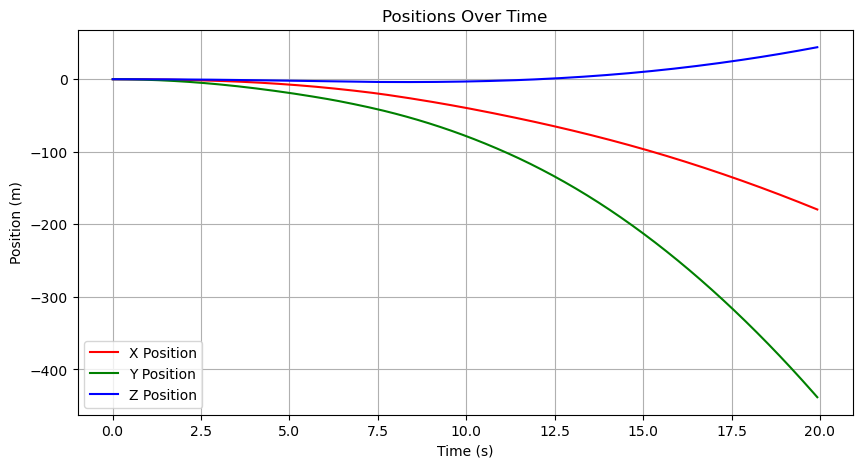

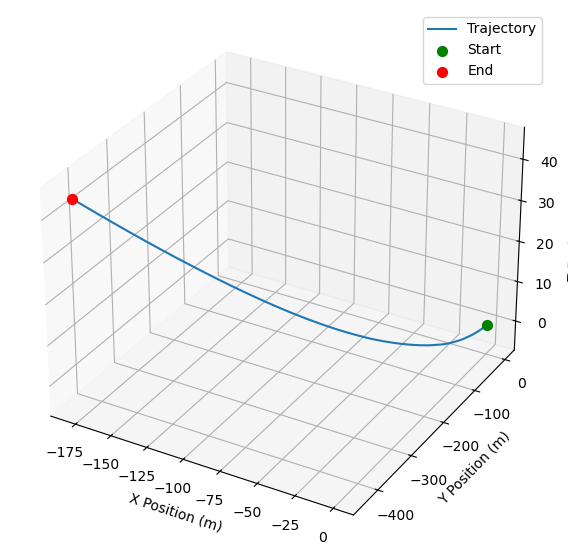

In [12]:
trajectory(time, np.deg2rad(angular_velocity), acceleration)